# Proyecto Ising

In [1]:
#Bibliotecas utilizadas
import numpy as np #cálculos matemáticos más complejos
import matplotlib.pyplot as plt #generar gráficas
import time #evaluar tiempos

## Hamiltoniano

In [2]:
class Hamiltoniano: #se define la clase Hamiltoniano
  def __init__(self, J, g, N):
    self.J = J #atributo: escala energética de interacción ferromagnética
    self.g = g #atributo: parámetro energético de campo transversal
    self.N = N #atributo: cantidad de espines del sistema

  def pauliX(self): #método: construye matriz X de Pauli
    return np.array([[0,1],[1,0]])

  def pauliZ(self): #método: construye matriz Z de Pauli
      return np.array([[1,0],[0,-1]])

  def identidad(self): #método: contruye matriz identidad
      return np.array([[1,0],[0,1]])

  def productoTensorial(self, matrizA, matrizB): #método: calcula el producto tensorial de dos matrices
    #se calculan las dimensiones de las matrices
    m = len(matrizA)
    n = len(matrizA[0])
    p = len(matrizB)
    q = len(matrizB[0])
    
    result = np.zeros((m * p, n * q)) #inicialización de matriz de resultados

    #se calcula el producto tensorial
    for i in range(m):
        for j in range(n):
            for k in range(p):
                for l in range(q):
                    result[i * p + k][j * q + l] = matrizA[i][j] * matrizB[k][l] #se realiza el producto para cada combinación de elementos de A y B y lo ubica en el lugar apropiado de la matriz result

    return result #retorna la matriz de resultados

    
  def ordenadorX(self, i): #método: ordena correctamente el producto tensorial para la sumatoria de matrices X de Pauli
    result = self.identidad() #inicializa la matriz de resultados como una matriz identidad
    
    for k in range(1, self.N + 1): #debe tomar en cuenta el valor de N
        if k == 1: #primera iteración
            if k == i: #donde i corresponde al índice de la sumatoria
                result = self.pauliX()
            else:
                result = self.identidad()
        else: #para las demás iteraciones en el rango establecido
            if k == i:
                result = self.productoTensorial(result, self.pauliX()) #si k coincide con el índice de la sumatoria
            else:
                result = self.productoTensorial(result, self.identidad()) #si k es distinto del índice de la sumatoria
    return result #retorna la matriz de resultados

    #ordenar productos tensoriales para z
  def ordenadorZ(self, i): #método: ordena correctamente el producto tensorial para la sumatoria de matrices Z de Pauli
    result = self.identidad() #inicializa la matriz de resultados como una matriz identidad

    for k in range(1, self.N + 1): #debe tomar en cuenta el valor de N
        if k == 1: #primera iteración
            if k == i: #donde i corresponde al índice de la sumatoria
                result = self.pauliZ()
            else:
                result = self.identidad()
        elif k == i or k == i+1: #para los casos presentes en la sumatoria
            result = self.productoTensorial(result, self.pauliZ())
        else: #para las demás iteraciones en el rango establecido
            result = self.productoTensorial(result, self.identidad())
    return result #retorna la matriz de resultados

    
  def construirHamiltoniano(self): #método: construye el hamiltoniano
    sumZ = np.zeros((2**self.N, 2**self.N)) #inicializa una matriz resultado de tamaño apropiado
    for i in range(1, self.N): #realiza la sumatoria
        sumZ += self.ordenadorZ(i)
    sumZ *= -self.J #multiplica la suma resultante por el parámetro J

    sumX = np.zeros((2**self.N, 2**self.N)) #inicializa una matriz resultado de tamaño apropiado
    for i in range(1, self.N + 1): #realiza la sumatoria
        sumX += self.ordenadorX(i)
    sumX *= -self.g #multiplica la suma resultante por el parámetro g

    return sumZ + sumX #retorna el hamiltoniano resultante

In [3]:
#imprimir hamiltoniano (solo para verificar y valores pequños)
t1 = time.time()
Ham = Hamiltoniano(1, 1, 10) #se establecen los parámetros del hamiltoniano
H = Ham.construirHamiltoniano() #se construye el hamiltoniano
t2 = time.time()

print(H)
print(t2-t1)

[[-9. -1. -1. ... -0. -0. -0.]
 [-1. -7. -0. ... -0. -0. -0.]
 [-1. -0. -5. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ... -5. -0. -1.]
 [-0. -0. -0. ... -0. -7. -1.]
 [-0. -0. -0. ... -1. -1. -9.]]
34.682451248168945


## Solución de la dinámica

In [4]:
#definir variables
tList = np.linspace(0, 10, 1000) #se define la grilla temporal
h = tList[1]-tList[0] #se define el timestep

In [5]:
#inicializar vector inicial
def vectorPsiInit(N):
    vec = np.zeros(2**N) #se crea un vector de zeros de tamaño apropiado con base a la cantidad de espines
    vec[0] = 1 #en t=0, el vector inicial será un 1 en la primera entrada con 0 en las demás
    return vec #retorna el vector inicial

### Implementación RK4

In [50]:
#derivada de la funcion
def derivadaVectorPsi(state, oper): 
    return -1.0j * np.matmul(oper, state) #retorna la derivada de la función a evaluar

In [51]:
#se define funcion rk4 visto en clase
def rk4(func, oper, state, h):
    k_1 = h*func(oper,state)
    k_2 = h*func(oper,state+((k_1)/2))
    k_3 = h*func(oper,state+((k_2)/2))
    k_4 = h*func(oper,state+k_3)
    return state + (k_1 + 2*k_2 + 2*k_3 + k_4)*(1/6)

In [186]:
#se implementa el resultado
inicio_rk4 = time.time() #se obtiene el tiempo en el que inicia el proceso

vectorPsiRK4 = np.zeros(tList.size) #se inicializa el vector de resultados del tamaño de la grilla temporal en zeros
vecRK4 = vectorPsiInit(10) #se establece el vector inicial de tamaño 2^N (por ejemplo, con N=10)

for i in range(tList.size): #se crea el ciclo que evalúa el método RK4 entrada por entrada
    vectorPsiRK4[i] = vecRK4[0].real
    vectorPsiN = rk4(derivadaVectorPsi, H, vecRK4, h)
    vecRK4 = vectorPsiN

final_rk4 = time.time() #se obtiene el tiempo en que termina el proceso
print('Duración: ', final_rk4 - inicio_rk4,'s') #se imprime la duración mediante la diferencia de tiempo final e inicial

Duración:  35.61168050765991 s


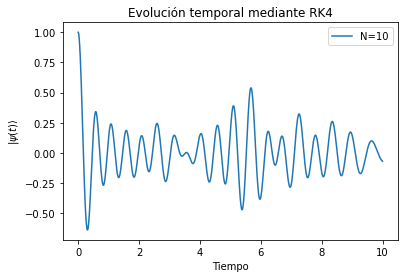

In [197]:
#se grafica la evolución mediante el método RK4
plt.plot(tList, vectorPsiRK4, label = 'N=10')
plt.title('Evolución temporal mediante RK4')
plt.xlabel('Tiempo')
plt.ylabel(r'$|\psi(t) \rangle$')
plt.legend()
plt.show()


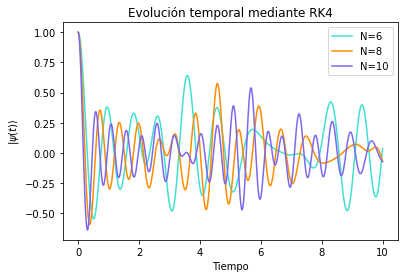

In [192]:
#se grafica la comparación de evolución mediante RK4 para 6, 8 y 10 espines
plt.plot(tList, vectorPsiRK4_6, color='turquoise', linestyle='-', label='N=6')
plt.plot(tList, vectorPsiRK4_8, color='darkorange', linestyle='-', label='N=8')
plt.plot(tList, vectorPsiRK4_10, color='mediumslateblue', linestyle='-', label='N=10')
plt.title('Evolución temporal mediante RK4')
plt.xlabel('Tiempo')
plt.ylabel(r'$|\psi(t) \rangle$')
plt.legend()
plt.show

plt.savefig('RK4.png')

### Solución Directa (Diagonalización)

In [6]:
def diagonalizacion(t, t_0, vec, eigVals, eigVecs): #se resuelve la ecuación mediante diagonalización
    # base diagonal
    eigVals = -1.0j * eigVals * (t - t_0) #se multiplican los valores propios del hamiltoniano por -i y la diferencia de tiempo
    expVals = np.exp(eigVals) #se exponencian los valores propios
    expD = np.diag(expVals) #se construye la matriz diagonal
    
    psi_d = np.dot(eigVecs.T, vec) #se multiplica el la matriz transpuesta de valores propios con el vector inicial, es decir, este se proyecta en la base diagonal
    psi_t_d = np.dot(expD, psi_d) #se evalúa la evolución temporal en la base diagonal
    
    #base original
    psi_t = np.dot(eigVecs, psi_t_d) #se proyecta el el vector evolucionado a la base original
    
    return psi_t #devuelve la evolución en la base original

In [7]:
#implementación de la solución directa por diagonalización
inicio_diag = time.time() #se obtiene el tiempo en el que inicia el proceso


vectorPsiDiag = np.zeros(tList.size) #se inicializa el vector de resultados del tamaño de la grilla temporal en zeros
vecDiag = vectorPsiInit(10) #se establece el vector inicial de tamaño 2^N (por ejemplo, con N=10)
vecDiagCopy = vecDiag.copy() #se realiza una copia del vector inicial sobre la cual trabajar

autoVal, autoVec = np.linalg.eigh(H) #se obtienen los autovalores y autovectores del hamiltoniano

for i in range(tList.size): #se crea el ciclo que evalúa el método de diagonalización entrada por entrada
    vectorPsiDiag[i] = vecDiag[0].real
    vectorPsiN = diagonalizacion(tList[i], tList[0], vecDiagCopy, autoVal, autoVec)
    vecDiag = vectorPsiN
    
final_diag = time.time() #se obtiene el tiempo en el que termina el proceso
print('Duración: ', final_diag - inicio_diag,'s') #se imprime la duración mediante la diferencia de tiempo final e inicial

Duración:  14.276237487792969 s


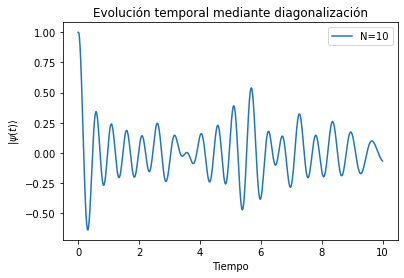

In [8]:
#se grafica la evolución mediante el método de diagonalización
plt.plot(tList, vectorPsiDiag, label='N=10')
plt.title('Evolución temporal mediante diagonalización')
plt.xlabel('Tiempo')
plt.ylabel(r'$|\psi(t) \rangle$')
plt.legend()
plt.show()


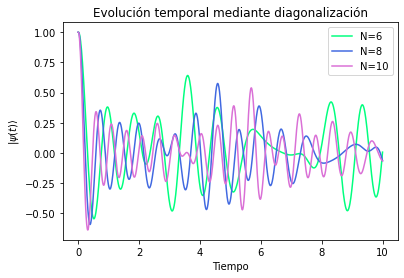

In [198]:
#se grafica la comparación de evolución mediante diagonalización para 6, 8 y 10 espines

plt.plot(tList, vectorPsiDiag_6, color='springgreen', linestyle='-', label='N=6')
plt.plot(tList, vectorPsiDiag_8, color='royalblue', linestyle='-', label='N=8')
plt.plot(tList, vectorPsiDiag_10, color='orchid', linestyle='-', label='N=10')
plt.title('Evolución temporal mediante diagonalización')
plt.xlabel('Tiempo')
plt.ylabel(r'$|\psi(t) \rangle$')
plt.legend()
plt.show

plt.savefig('Diag.png')